In [1]:
# CELL 1 — Setup, load CSV, basic EDA (preview + season counts plot)

# If you're in Colab and missing packages, uncomment the next line:
# !pip -q install pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty display options
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)



In [2]:
# === 1) Load your combined CSV ===
DATA_CSV = "epl_combined_data_2020_2024.csv"  # <-- change path/name if needed

df_raw = pd.read_csv(DATA_CSV)
df_raw.columns = [c.strip() for c in df_raw.columns]

# Parse Date (Football-Data is day-first)
if "Date" not in df_raw.columns:
    raise ValueError("Your CSV must include a 'Date' column.")
df_raw["Date"] = pd.to_datetime(df_raw["Date"], dayfirst=True, errors="coerce")
df_raw = df_raw.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# Keep only Premier League if 'Div' exists
if "Div" in df_raw.columns:
    df_raw = df_raw[df_raw["Div"].eq("E0")].copy()

# Ensure we have core columns
required = ["HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "Season"]
missing = [c for c in required if c not in df_raw.columns]
if missing:
    print("WARNING: Missing required columns:", missing)



In [3]:
# === 2) Quick overview ===
print("Rows:", len(df_raw))
print("Columns:", len(df_raw.columns))
print("Date range:", df_raw["Date"].min(), "→", df_raw["Date"].max())
print("Seasons found:", sorted(df_raw["Season"].unique().tolist()))

print("\nColumn names:")
print(df_raw.columns.tolist())

print("\nSample rows:")
display(df_raw.head(5))




Rows: 1990
Columns: 163
Date range: 2020-09-12 00:00:00 → 2025-10-26 00:00:00
Seasons found: ['2020-21', '2021-22', '2022-23', '2023-24', '2024-25', '2025-26']

Column names:
['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,...,MaxCAHA,AvgCAHH,AvgCAHA,Season,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,BFDH,BFDD,BFDA,BMGMH,BMGMD,BMGMA,BVH,BVD,BVA,CLH,CLD,CLA,LBH,LBD,LBA,BFDCH,BFDCD,BFDCA,BMGMCH,BMGMCD,BMGMCA,BVCH,BVCD,BVCA,CLCH,CLCD,CLCA,LBCH,LBCD,LBCA
0,E0,2020-09-12,12:30,Fulham,Arsenal,0,3,A,0,1,A,C Kavanagh,5,13,2,6,12,12,2,3,2,2,0,0,6.00,4.33,1.53,5.50,4.25,1.57,6.00,3.90,1.57,6.16,4.51,1.56,6.50,4.2,1.53,6.50,4.20,1.55,6.55,4.55,1.60,5.94,4.34,1.55,1.72,2.10,1.80,2.13,1.84,2.18,1.76,2.10,1.00,1.93,1.97,1.96,...,1.92,2.02,1.87,2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2020-09-12,15:00,Crystal Palace,Southampton,1,0,H,1,0,H,J Moss,5,9,3,5,14,11,7,3,2,1,0,0,3.10,3.25,2.37,3.00,3.20,2.45,3.15,2.95,2.40,3.32,3.29,2.40,3.20,3.2,2.35,3.20,3.20,2.40,3.36,3.36,2.50,3.18,3.22,2.39,2.20,1.66,2.34,1.68,2.36,1.73,2.24,1.67,0.25,1.85,2.05,1.88,...,2.18,1.79,2.12,2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2020-09-12,17:30,Liverpool,Leeds,4,3,H,3,2,H,M Oliver,22,6,6,3,9,6,9,0,1,0,0,0,1.28,6.00,9.50,1.26,6.25,10.50,1.35,5.00,8.50,1.31,6.25,9.92,1.27,6.0,10.00,1.30,5.75,10.50,1.35,6.50,10.75,1.30,5.96,9.68,1.53,2.50,1.56,2.60,1.56,2.68,1.52,2.53,-1.50,1.95,1.95,1.97,...,2.16,1.84,2.04,2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2020-09-12,20:00,West Ham,Newcastle,0,2,A,0,0,D,S Attwell,15,15,3,2,13,7,8,7,2,2,0,0,2.15,3.40,3.40,2.15,3.40,3.40,2.15,3.15,3.40,2.18,3.61,3.50,2.15,3.5,3.40,2.15,3.40,3.60,2.24,3.70,3.60,2.15,3.48,3.42,1.90,1.90,2.00,1.91,2.05,1.95,1.97,1.86,-0.50,2.07,1.72,2.17,...,1.91,2.02,1.86,2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2020-09-13,14:00,West Brom,Leicester,0,3,A,0,0,D,A Taylor,7,13,1,7,12,9,2,5,1,1,0,0,3.80,3.60,1.95,3.70,3.60,2.00,3.85,3.20,2.00,4.00,3.59,2.00,3.80,3.6,1.95,4.00,3.50,1.95,4.00,3.82,2.04,3.87,3.57,1.97,1.90,1.90,2.00,1.91,2.02,2.03,1.92,1.90,0.50,1.91,1.99,1.92,...,2.01,1.91,1.97,2020-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


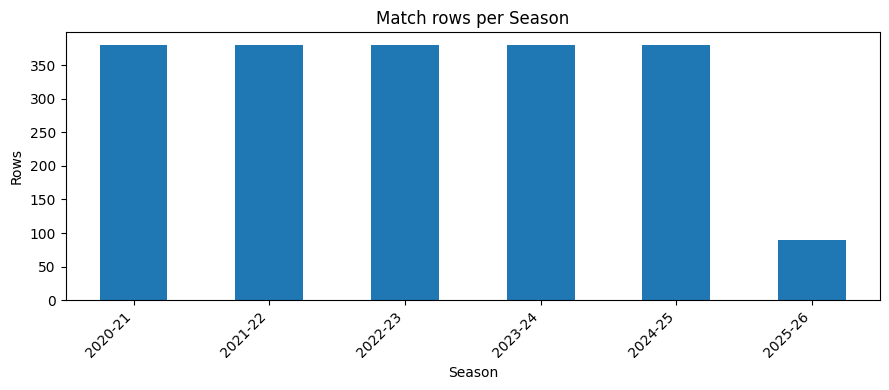

In [4]:
# === 3) Season-wise match counts plot ===
matches_per_season = (
    df_raw.groupby("Season")
          .size()
          .reindex(sorted(df_raw["Season"].unique()), fill_value=0)
)

plt.figure(figsize=(9, 4))
matches_per_season.plot(kind="bar")
plt.title("Match rows per Season")
plt.xlabel("Season")
plt.ylabel("Rows")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [5]:
# CELL 2 — Team-centric table + safe stat merge + rolling features + Elo + quick visuals

import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) Build team-centric long table (two rows per match) ----------
def explode_matches(df):
    rows = []
    for _, r in df.iterrows():
        # Home perspective
        rows.append({
            'Date': r['Date'],
            'Season': r['Season'],
            'Team': r['HomeTeam'],
            'Opponent': r['AwayTeam'],
            'is_home': 1,
            'goals_for': r['FTHG'],
            'goals_against': r['FTAG'],
            'result': 'W' if r['FTHG']>r['FTAG'] else ('D' if r['FTHG']==r['FTAG'] else 'L')
        })
        # Away perspective
        rows.append({
            'Date': r['Date'],
            'Season': r['Season'],
            'Team': r['AwayTeam'],
            'Opponent': r['HomeTeam'],
            'is_home': 0,
            'goals_for': r['FTAG'],
            'goals_against': r['FTHG'],
            'result': 'W' if r['FTAG']>r['FTHG'] else ('D' if r['FTAG']==r['FTHG'] else 'L')
        })
    long_df = pd.DataFrame(rows).sort_values('Date').reset_index(drop=True)
    long_df['points'] = long_df['result'].map({'W':3,'D':1,'L':0})
    return long_df

long = explode_matches(df_raw)
print("Long table shape:", long.shape)
display(long.head(3))




Long table shape: (3980, 9)


,Date,Season,Team,Opponent,is_home,goals_for,goals_against,result,points
0,2020-09-12,2020-21,Fulham,Arsenal,1,0,3,L,0
1,2020-09-12,2020-21,Arsenal,Fulham,0,3,0,W,3
2,2020-09-12,2020-21,Crystal Palace,Southampton,1,1,0,W,3


In [6]:
# ---------- 2) Safely attach raw match stats/odds (handles missing columns) ----------
def attach_stats_safe(raw, long):
    candidate_cols = [
        'HS','HST','HF','HC','HY','HR',
        'AS','AST','AF','AC','AY','AR',
        'B365H','B365D','B365A'
    ]
    present_cols = [c for c in candidate_cols if c in raw.columns]
    raw_key = raw[['Date','HomeTeam','AwayTeam'] + present_cols].copy()

    home_view = long.merge(
        raw_key, left_on=['Date','Team','Opponent'],
        right_on=['Date','HomeTeam','AwayTeam'], how='left'
    )
    away_view = long.merge(
        raw_key, left_on=['Date','Opponent','Team'],
        right_on=['Date','HomeTeam','AwayTeam'], how='left'
    )

    out = long.copy()
    for c in present_cols:
        out[c] = home_view[c].combine_first(away_view[c])

    def get(col, default=np.nan):
        return out[col] if col in out.columns else pd.Series(default, index=out.index)

    HS, AS_ = get('HS'), get('AS')
    HST, AST = get('HST'), get('AST')
    HF, AF = get('HF'), get('AF')
    HC, AC = get('HC'), get('AC')
    HY, AY = get('HY'), get('AY')
    HR, AR = get('HR'), get('AR')

    out['shots_for']       = np.where(out['is_home']==1, HS, AS_)
    out['shots_against']   = np.where(out['is_home']==1, AS_, HS)
    out['sot_for']         = np.where(out['is_home']==1, HST, AST)
    out['sot_against']     = np.where(out['is_home']==1, AST, HST)
    out['fouls']           = np.where(out['is_home']==1, HF, AF)
    out['fouls_against']   = np.where(out['is_home']==1, AF, HF)
    out['corners']         = np.where(out['is_home']==1, HC, AC)
    out['corners_against'] = np.where(out['is_home']==1, AC, HC)
    out['yellows']         = np.where(out['is_home']==1, HY, AY)
    out['reds']            = np.where(out['is_home']==1, HR, AR)

    if all(x in out.columns for x in ['B365H','B365D','B365A']):
        out['odds_team_win'] = np.where(out['is_home']==1, out['B365H'], out['B365A'])
        out['odds_draw']     = out['B365D']
        out['odds_opp_win']  = np.where(out['is_home']==1, out['B365A'], out['B365H'])
    else:
        out['odds_team_win'] = np.nan
        out['odds_draw']     = np.nan
        out['odds_opp_win']  = np.nan

    return out

long = attach_stats_safe(df_raw, long)
print("After attach, columns:", len(long.columns))



After attach, columns: 37


In [7]:
# ---------- 3) Add rolling features + simple single-team Elo ----------
def compute_elo_for_team_group(g, K=20.0, base=1500.0):
    elo = base
    elos = []
    for _, r in g.iterrows():
        # expected score vs league-average opponent
        Ea = 1.0 / (1.0 + 10 ** ((base - elo) / 400))
        s = 1.0 if r['result'] == 'W' else (0.5 if r['result'] == 'D' else 0.0)
        elo = elo + K * (s - Ea)
        elos.append(elo)
    return pd.Series(elos, index=g.index)

def add_rolling_features(long, windows=(5,10)):
    long = long.sort_values('Date').copy()
    frames = []
    for team, g in long.groupby('Team'):
        g = g.sort_values('Date').copy()
        g['elo'] = compute_elo_for_team_group(g)
        for w in windows:
            g[f'roll{w}_ppg']   = g['points'].rolling(w, min_periods=1).mean()
            g[f'roll{w}_gfpg']  = g['goals_for'].rolling(w, min_periods=1).mean()
            g[f'roll{w}_gapg']  = g['goals_against'].rolling(w, min_periods=1).mean()
            g[f'roll{w}_sotpg'] = g['sot_for'].rolling(w, min_periods=1).mean()
            g[f'roll{w}_sotapg']= g['sot_against'].rolling(w, min_periods=1).mean()
            g[f'roll{w}_shpg']  = g['shots_for'].rolling(w, min_periods=1).mean()
            g[f'roll{w}_shapg'] = g['shots_against'].rolling(w, min_periods=1).mean()
        frames.append(g)
    return pd.concat(frames, ignore_index=True)

long = add_rolling_features(long, windows=(5,10))
print("Feature columns now:", [c for c in long.columns if c.startswith('roll') or c=='elo'][:10], "...")



Feature columns now: ['elo', 'roll5_ppg', 'roll5_gfpg', 'roll5_gapg', 'roll5_sotpg', 'roll5_sotapg', 'roll5_shpg', 'roll5_shapg', 'roll10_ppg', 'roll10_gfpg'] ...


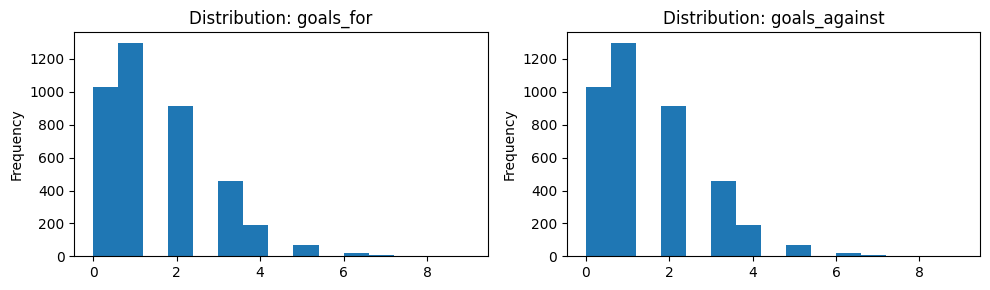

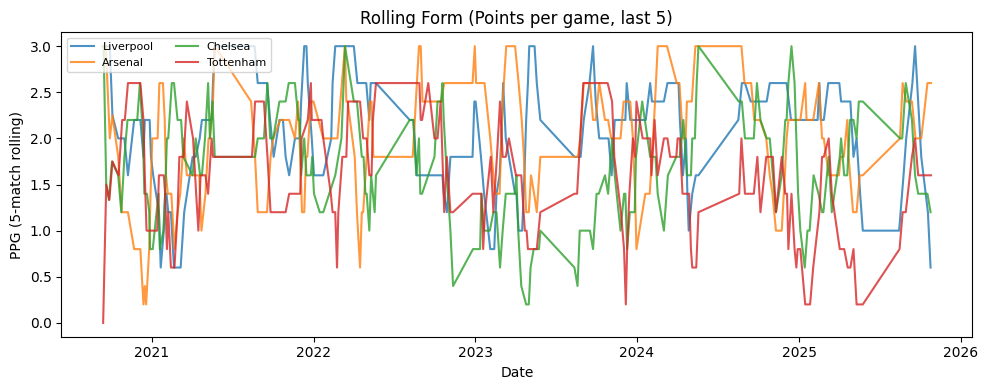

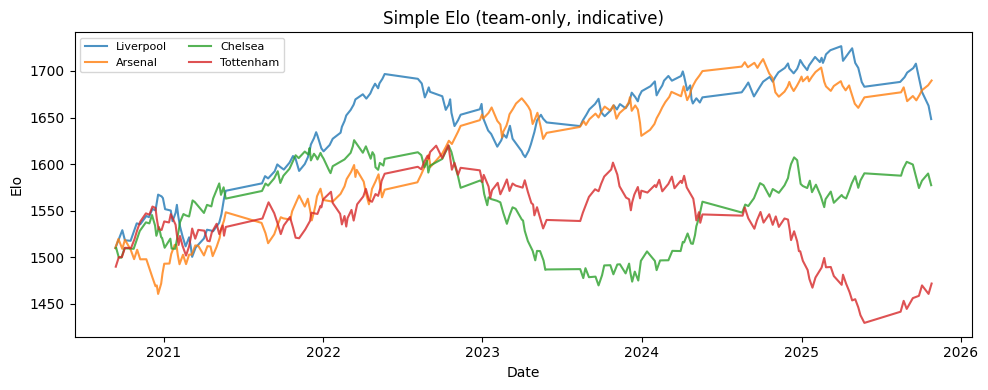

Long table ready for fixture-level modeling.


In [8]:
# ---------- 4) Quick visual diagnostics ----------
# Distribution of goals for/against
fig, ax = plt.subplots(1,2, figsize=(10,3))
long['goals_for'].plot(kind='hist', bins=15, ax=ax[0])
ax[0].set_title('Distribution: goals_for')
long['goals_against'].plot(kind='hist', bins=15, ax=ax[1])
ax[1].set_title('Distribution: goals_against')
plt.tight_layout()
plt.show()

# Rolling form (PPG last 5) for a few popular teams across seasons
teams_to_plot = ['Manchester City','Liverpool','Arsenal','Chelsea','Manchester United','Tottenham']
subset = long[long['Team'].isin(teams_to_plot)].copy()

plt.figure(figsize=(10,4))
for t in teams_to_plot:
    g = subset[subset['Team']==t].sort_values('Date')
    if len(g):
        plt.plot(g['Date'], g['roll5_ppg'], label=t, alpha=0.8)
plt.legend(loc='upper left', ncols=2, fontsize=8)
plt.title('Rolling Form (Points per game, last 5)')
plt.xlabel('Date'); plt.ylabel('PPG (5-match rolling)')
plt.tight_layout(); plt.show()

# Elo trajectories (single-team Elo) for same teams
plt.figure(figsize=(10,4))
for t in teams_to_plot:
    g = subset[subset['Team']==t].sort_values('Date')
    if len(g):
        plt.plot(g['Date'], g['elo'], label=t, alpha=0.8)
plt.legend(loc='upper left', ncols=2, fontsize=8)
plt.title('Simple Elo (team-only, indicative)')
plt.xlabel('Date'); plt.ylabel('Elo')
plt.tight_layout(); plt.show()

print("Long table ready for fixture-level modeling.")

Unique matches in df_raw: 1990
Rows in long: 3980
Long rows with match_id: 3980
Value counts of rows per match_id (expect ~2 for all):
2    1990
Name: count, dtype: int64

Home rows: 1990 Away rows: 1990

Fixture-level rows: (1990, 41)


,Date,Season,HomeTeam_name,AwayTeam_name,label,elo_home,elo_away
0,2020-09-19,2020-21,Arsenal,West Ham,H,1519.712256,1480.287744
1,2020-10-04,2020-21,Arsenal,Sheffield United,H,1518.882332,1461.691413
2,2020-10-25,2020-21,Arsenal,Leicester,A,1498.099409,1517.558161


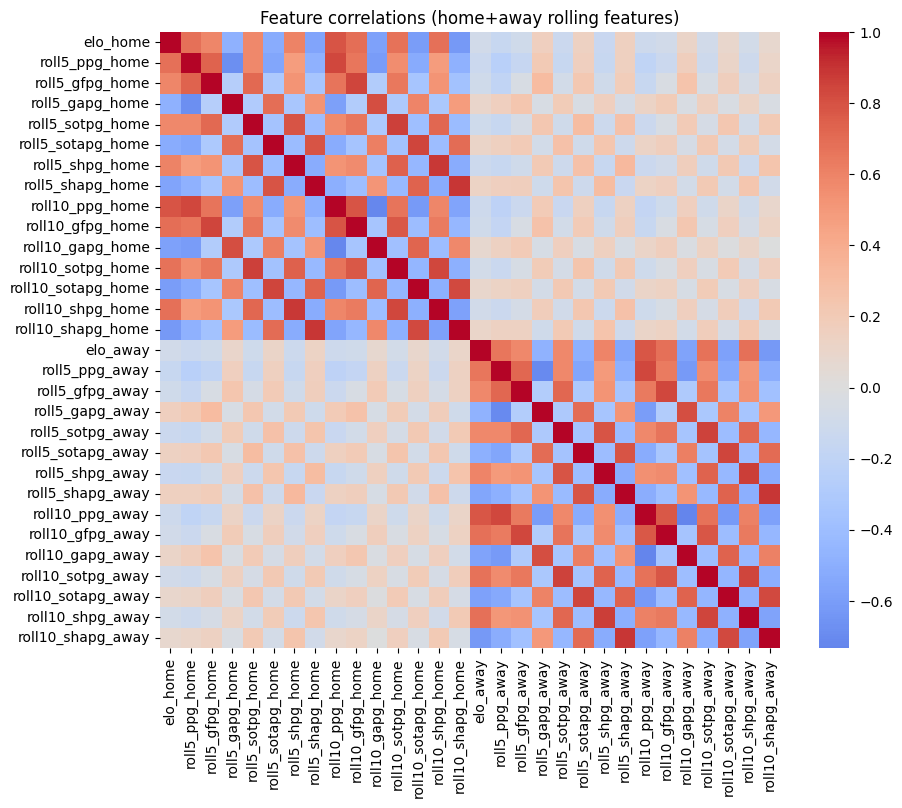

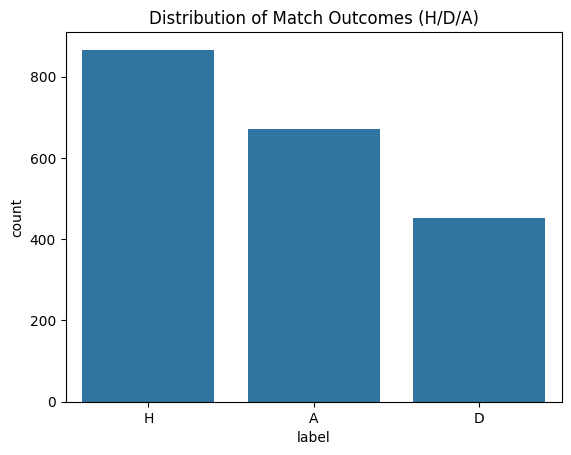

n_samples for training: 1990

Baseline Logistic — Accuracy: 0.679 | Log loss: 0.725 | Train n=1492 | Test n=498


c:\Users\Arkin Kansra\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


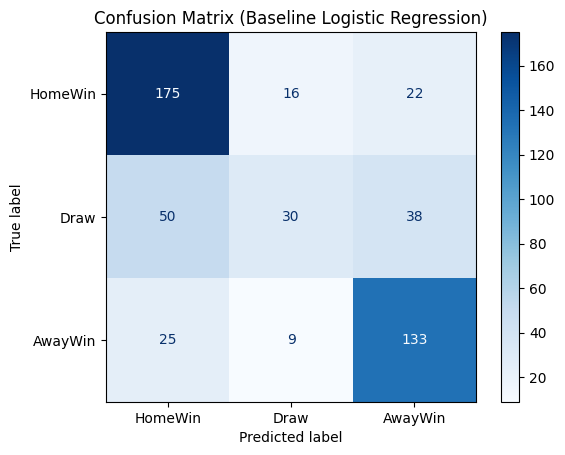

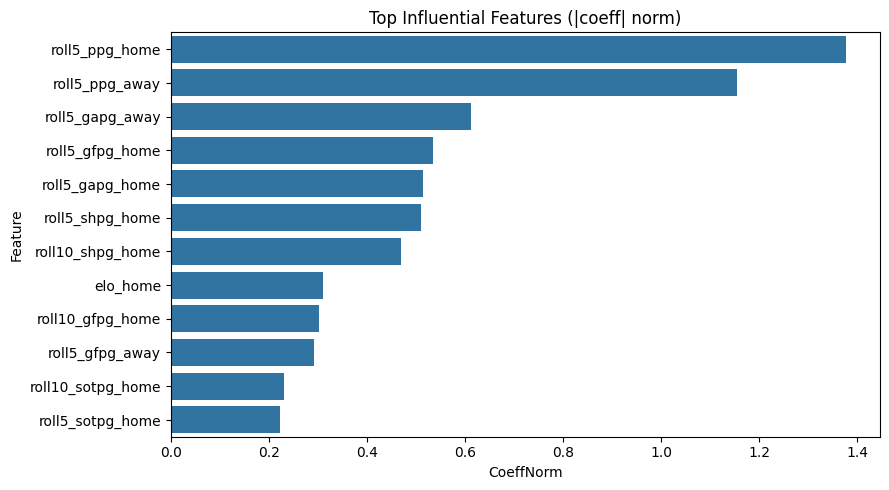

In [9]:
# CELL 3 (FIXED) — Robust fixture table via match_id + EDA + baseline model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# -- A) Create a robust match_id on the raw table and propagate to the long table --
df_raw = df_raw.sort_values(['Date','HomeTeam','AwayTeam']).reset_index(drop=True).copy()
df_raw['match_id'] = np.arange(len(df_raw))  # unique id per raw match row

# map match_id to long rows (works for both home/away perspective via coalescing two merges)
key_cols = ['Date','HomeTeam','AwayTeam','match_id']
home_map = long.merge(df_raw[key_cols], left_on=['Date','Team','Opponent'],
                      right_on=['Date','HomeTeam','AwayTeam'], how='left')
away_map = long.merge(df_raw[key_cols], left_on=['Date','Opponent','Team'],
                      right_on=['Date','HomeTeam','AwayTeam'], how='left')

long['match_id'] = home_map['match_id'].combine_first(away_map['match_id'])

# Debug prints
print("Unique matches in df_raw:", df_raw['match_id'].nunique())
print("Rows in long:", len(long))
print("Long rows with match_id:", long['match_id'].notna().sum())

# Sanity: we expect exactly 2 long rows per match_id
dup_check = long.groupby('match_id').size().dropna()
print("Value counts of rows per match_id (expect ~2 for all):")
print(dup_check.value_counts().head())

# -- B) Build fixture-level dataset by inner-joining home/away long rows on match_id --
home = long[(long['is_home'] == 1) & (long['match_id'].notna())].copy()
away = long[(long['is_home'] == 0) & (long['match_id'].notna())].copy()

print("\nHome rows:", len(home), "Away rows:", len(away))

# select pre-match features to carry (rolling + elo)
feat_cols_team = [c for c in long.columns if any(k in c for k in ['elo','roll5_','roll10_'])]

home_keep = ['match_id','Date','Season','Team','Opponent','goals_for','goals_against','result'] + feat_cols_team
away_keep = ['match_id','Team','Opponent'] + feat_cols_team

fixtures = home[home_keep].merge(
    away[away_keep],
    on='match_id', how='inner',
    suffixes=('_home','_away')
)

# after join, ensure the teams align: home.Team == away.Opponent and vice versa
ok = (fixtures['Team_home'] == fixtures['Opponent_away']) & (fixtures['Opponent_home'] == fixtures['Team_away'])
if not ok.all():
    print("WARNING: Some joined rows have mismatched teams; filtering them.")
    fixtures = fixtures[ok].copy()

# derive label from true home goals
fixtures['label'] = np.where(
    fixtures['goals_for'] > fixtures['goals_against'], 'H',
    np.where(fixtures['goals_for'] == fixtures['goals_against'], 'D', 'A')
)

# tidy columns
fixtures.rename(columns={
    'Team_home':'HomeTeam_name',
    'Team_away':'AwayTeam_name'
}, inplace=True)

# report shape & sample
print("\nFixture-level rows:", fixtures.shape)
display(fixtures.head(3)[[
    'Date','Season','HomeTeam_name','AwayTeam_name','label'
] + [c for c in fixtures.columns if c.startswith('elo_')][:4]])

# -- C) Quick EDA: correlations & label balance --
numeric_feats = [c for c in fixtures.columns if any(x in c for x in ['elo_','roll5_','roll10_'])]
if len(numeric_feats) == 0:
    raise RuntimeError("No numeric rolling features found on fixtures. Check Cell 2 completed successfully.")

plt.figure(figsize=(10,8))
sns.heatmap(fixtures[numeric_feats].corr(), cmap="coolwarm", center=0)
plt.title("Feature correlations (home+away rolling features)")
plt.show()

sns.countplot(x='label', data=fixtures)
plt.title("Distribution of Match Outcomes (H/D/A)")
plt.show()

# -- D) Baseline model (random split just to sanity check signal) --
feature_cols = numeric_feats
X = fixtures[feature_cols].values
y = fixtures['label'].map({'H':0,'D':1,'A':2}).values

n_samples = X.shape[0]
print("n_samples for training:", n_samples)

if n_samples == 0:
    raise RuntimeError("Fixture table is empty after join — cannot train. Please share the last few printed diagnostics.")

# If very small dataset (rare), set a smaller test set
test_size = 0.25 if n_samples >= 20 else 0.2 if n_samples >= 10 else 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=True, random_state=42
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

model = LogisticRegression(max_iter=600, multi_class='multinomial')
model.fit(X_train_s, y_train)
proba = model.predict_proba(X_test_s)
y_pred = np.argmax(proba, axis=1)

acc = accuracy_score(y_test, y_pred)
ll = log_loss(y_test, proba)
print(f"\nBaseline Logistic — Accuracy: {acc:.3f} | Log loss: {ll:.3f} | Train n={len(y_train)} | Test n={len(y_test)}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['HomeWin','Draw','AwayWin'])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Baseline Logistic Regression)")
plt.show()

# Feature influence (coeff norms)
coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "CoeffNorm": np.linalg.norm(model.coef_, axis=0)
}).sort_values("CoeffNorm", ascending=False)

plt.figure(figsize=(9,5))
sns.barplot(data=coef_df.head(12), x='CoeffNorm', y='Feature')
plt.title("Top Influential Features (|coeff| norm)")
plt.tight_layout(); plt.show()


Seasons available: [2020, 2021, 2022, 2023, 2024, 2025]
Using season loop: 2021 .. 2025

Season 2021-22 | Train n=380 | Test n=380
  -> LogLoss=1.053 | Brier=0.185

Season 2022-23 | Train n=760 | Test n=380
  -> LogLoss=0.943 | Brier=0.176

Season 2023-24 | Train n=1140 | Test n=380
  -> LogLoss=0.732 | Brier=0.145

Season 2024-25 | Train n=1520 | Test n=380
  -> LogLoss=0.836 | Brier=0.166

Season 2025-26 | Train n=1900 | Test n=90
  -> LogLoss=0.809 | Brier=0.162


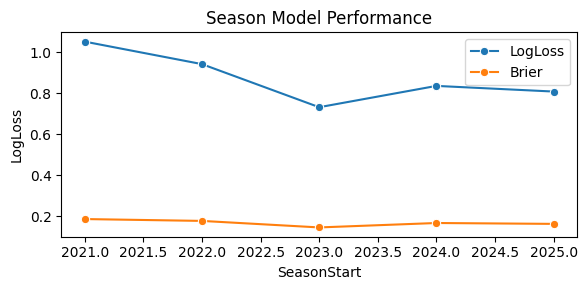

,SeasonStart,LogLoss,Brier
0,2021,1.052983,0.185491
1,2022,0.942991,0.176449
2,2023,0.732343,0.144565
3,2024,0.836496,0.166201
4,2025,0.808864,0.161919


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_26848\2635400912.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champ_df.head(10), x='ChampProb', y='Team', palette='viridis')


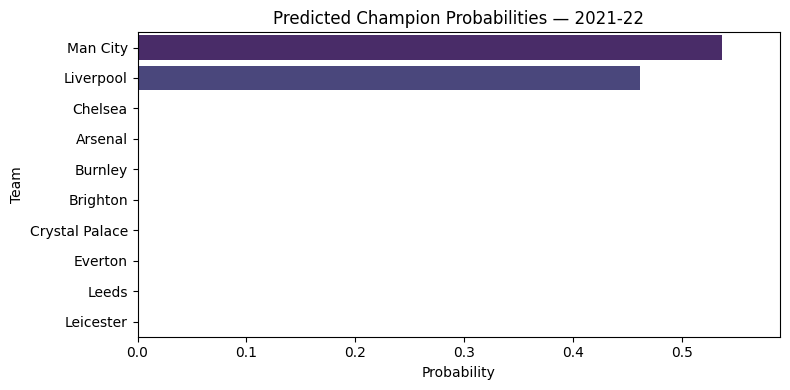


Top 10 Champion Probabilities 2021-22:



,Team,ChampProb
0,Man City,0.5366
1,Liverpool,0.4614
2,Chelsea,0.0014
3,Arsenal,0.0006
4,Burnley,0.0000
5,Brighton,0.0000
6,Crystal Palace,0.0000
7,Everton,0.0000
8,Leeds,0.0000
9,Leicester,0.0000


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_26848\2635400912.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champ_df.head(10), x='ChampProb', y='Team', palette='viridis')


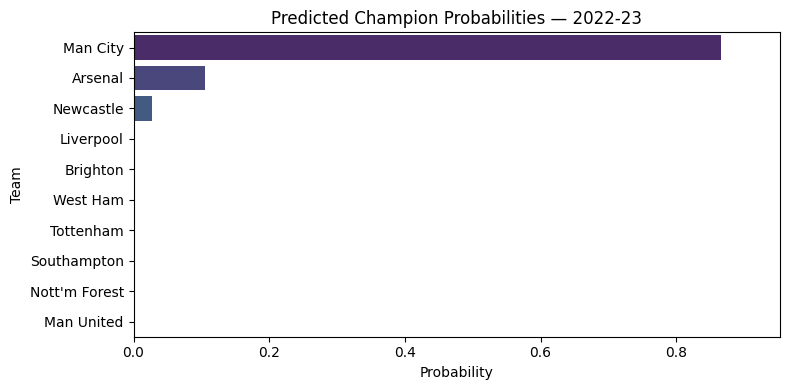


Top 10 Champion Probabilities 2022-23:



,Team,ChampProb
0,Man City,0.8664
1,Arsenal,0.1058
2,Newcastle,0.0270
3,Liverpool,0.0006
4,Brighton,0.0002
5,West Ham,0.0000
6,Tottenham,0.0000
7,Southampton,0.0000
8,Nott'm Forest,0.0000
9,Man United,0.0000


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_26848\2635400912.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champ_df.head(10), x='ChampProb', y='Team', palette='viridis')


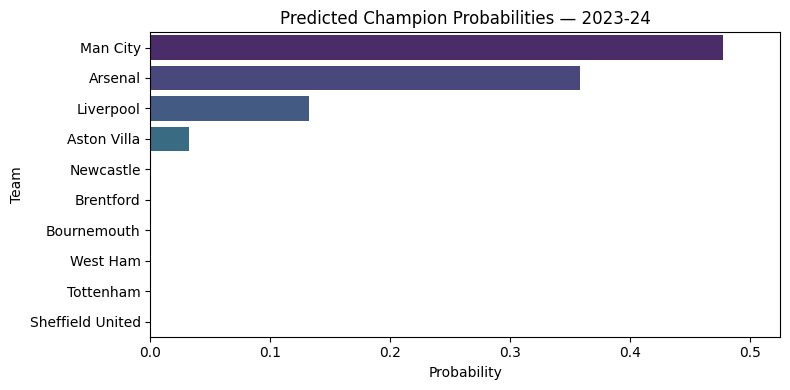


Top 10 Champion Probabilities 2023-24:



,Team,ChampProb
0,Man City,0.4770
1,Arsenal,0.3582
2,Liverpool,0.1324
3,Aston Villa,0.0322
4,Newcastle,0.0002
5,Brentford,0.0000
6,Bournemouth,0.0000
7,West Ham,0.0000
8,Tottenham,0.0000
9,Sheffield United,0.0000


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_26848\2635400912.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champ_df.head(10), x='ChampProb', y='Team', palette='viridis')


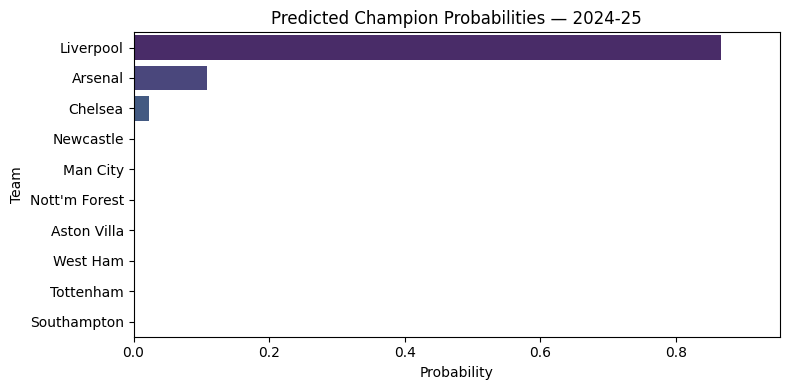


Top 10 Champion Probabilities 2024-25:



,Team,ChampProb
0,Liverpool,0.8668
1,Arsenal,0.1078
2,Chelsea,0.0232
3,Newcastle,0.0008
4,Man City,0.0008
5,Nott'm Forest,0.0004
6,Aston Villa,0.0002
7,West Ham,0.0000
8,Tottenham,0.0000
9,Southampton,0.0000


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_26848\2635400912.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=champ_df.head(10), x='ChampProb', y='Team', palette='viridis')


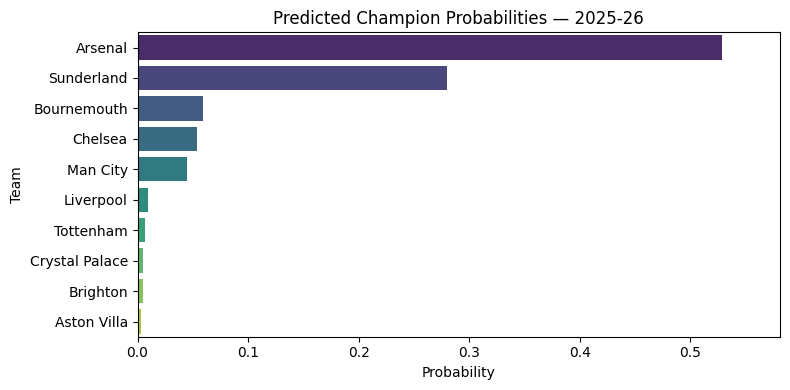


Top 10 Champion Probabilities 2025-26:



,Team,ChampProb
0,Arsenal,0.5284
1,Sunderland,0.2800
2,Bournemouth,0.0594
3,Chelsea,0.0538
4,Man City,0.0452
5,Liverpool,0.0092
6,Tottenham,0.0070
7,Crystal Palace,0.0050
8,Brighton,0.0046
9,Aston Villa,0.0028


In [10]:
# CELL 4 (ROBUST) — Season-aware training + Monte Carlo with safety checks

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, brier_score_loss
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def season_int(s):
    try:
        return int(str(s)[:4])
    except:
        return 0

fixtures['season_key'] = fixtures['Season'].apply(season_int)

# Determine safe start/end: start from (min+1) so there is at least one season to train on
min_season = fixtures['season_key'].min()
max_season = fixtures['season_key'].max()
safe_start = max(min_season + 1, 2020)  # you can change 2020 if you included older seasons

print(f"Seasons available: {sorted(fixtures['season_key'].unique().tolist())}")
print(f"Using season loop: {safe_start} .. {max_season}")

def train_season_models_safe(fixtures, start, end):
    results = {}
    feature_cols = [c for c in fixtures.columns if any(k in c for k in ['elo_','roll5_','roll10_'])]
    if not feature_cols:
        raise RuntimeError("No feature columns found (elo_/roll5_/roll10_). Check Cell 2 executed properly.")

    for season in range(start, end+1):
        train_idx = fixtures['season_key'] < season
        test_idx  = fixtures['season_key'] == season

        n_train = int(train_idx.sum())
        n_test  = int(test_idx.sum())
        print(f"\nSeason {season}-{str(season+1)[-2:]} | Train n={n_train} | Test n={n_test}")

        if n_train == 0 or n_test == 0:
            print("  -> Skipping (no train or no test rows).")
            continue

        X_train = fixtures.loc[train_idx, feature_cols].values
        y_train = fixtures.loc[train_idx, 'label'].map({'H':0,'D':1,'A':2}).values
        X_test  = fixtures.loc[test_idx, feature_cols].values
        y_test  = fixtures.loc[test_idx, 'label'].map({'H':0,'D':1,'A':2}).values

        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s  = scaler.transform(X_test)

        model = XGBClassifier(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            objective='multi:softprob',
            eval_metric='mlogloss',
            random_state=42
        )
        model.fit(X_train_s, y_train)
        proba = model.predict_proba(X_test_s)

        ll = log_loss(y_test, proba)
        briers = [brier_score_loss((y_test==i).astype(int), proba[:,i]) for i in range(3)]
        brier = float(np.mean(briers))
        print(f"  -> LogLoss={ll:.3f} | Brier={brier:.3f}")

        results[season] = {
            'model': model, 'scaler': scaler,
            'proba': proba, 'y_test': y_test,
            'test_df': fixtures.loc[test_idx].reset_index(drop=True),
            'logloss': float(ll), 'brier': brier
        }
    return results

results = train_season_models_safe(fixtures, start=safe_start, end=max_season)

# --- Monte Carlo simulation ---
def simulate_championship(result_obj, n_sims=5000, seed=42):
    rng = np.random.default_rng(seed)
    test = result_obj['test_df']
    proba = result_obj['proba']
    teams = pd.unique(pd.concat([test['HomeTeam_name'], test['AwayTeam_name']]))
    team_idx = {t:i for i,t in enumerate(teams)}
    champ_counts = np.zeros(len(teams), dtype=int)

    for _ in range(n_sims):
        pts = np.zeros(len(teams), dtype=int)
        outcomes = [rng.choice([0,1,2], p=p) for p in proba]  # 0=H,1=D,2=A
        for i, row in test.iterrows():
            h = team_idx[row['HomeTeam_name']]
            a = team_idx[row['AwayTeam_name']]
            o = outcomes[i]
            if o == 0:      # Home win
                pts[h] += 3
            elif o == 1:    # Draw
                pts[h] += 1; pts[a] += 1
            else:           # Away win
                pts[a] += 3
        champ_counts[np.argmax(pts)] += 1

    out = pd.DataFrame({'Team': teams, 'ChampProb': champ_counts/n_sims})
    return out.sort_values('ChampProb', ascending=False).reset_index(drop=True)

# --- Plot performance over seasons ---
metrics = []
for s, res in results.items():
    metrics.append([s, res['logloss'], res['brier']])

if metrics:
    metrics_df = pd.DataFrame(metrics, columns=['SeasonStart','LogLoss','Brier']).sort_values('SeasonStart')
    plt.figure(figsize=(6,3))
    sns.lineplot(data=metrics_df, x='SeasonStart', y='LogLoss', marker='o', label='LogLoss')
    sns.lineplot(data=metrics_df, x='SeasonStart', y='Brier', marker='o', label='Brier')
    plt.title('Season Model Performance')
    plt.legend(); plt.tight_layout(); plt.show()
    display(metrics_df)
else:
    print("No seasons trained (check data ranges).")

# --- Run & show champion probabilities per season ---
for season, res in results.items():
    champ_df = simulate_championship(res, n_sims=5000)
    plt.figure(figsize=(8,4))
    sns.barplot(data=champ_df.head(10), x='ChampProb', y='Team', palette='viridis')
    plt.title(f"Predicted Champion Probabilities — {season}-{str(season+1)[-2:]}")
    plt.xlabel('Probability')
    plt.xlim(0, champ_df['ChampProb'].max()*1.1)
    plt.tight_layout(); plt.show()

    print(f"\nTop 10 Champion Probabilities {season}-{str(season+1)[-2:]}:\n")
    display(champ_df.head(10))


C:\Users\Arkin Kansra\AppData\Local\Temp\ipykernel_26848\79486917.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cmp.head(10), x='ChampProb_whatif', y='Team', ax=ax[1], orient='h', palette='viridis')


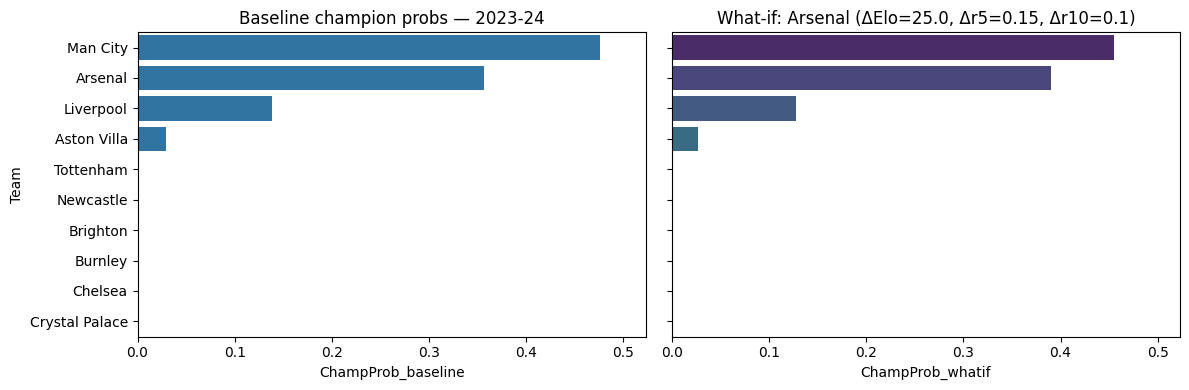


Top 12 comparison — 2023-24 (baseline vs what-if):


,Team,ChampProb_baseline,ChampProb_whatif,Delta
0,Man City,0.4754,0.4548,-0.0206
1,Arsenal,0.3560,0.3904,0.0344
2,Liverpool,0.1386,0.1274,-0.0112
3,Aston Villa,0.0294,0.0268,-0.0026
4,Tottenham,0.0004,0.0004,0.0000
5,Newcastle,0.0002,0.0002,0.0000
6,Brighton,0.0000,0.0000,0.0000
7,Burnley,0.0000,0.0000,0.0000
8,Chelsea,0.0000,0.0000,0.0000
9,Crystal Palace,0.0000,0.0000,0.0000


In [11]:
# CELL 5 — What-if: boost a team’s strength and re-simulate the season

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- choose scenario ---
which_season = 2023           # e.g., 2021, 2022, 2023 (based on your earlier printout)
team_to_boost = "Arsenal"     # exact name as appears in HomeTeam_name/AwayTeam_name
elo_delta = 25.0              # e.g., +25 Elo points
roll5_ppg_delta = 0.15        # add to roll5_ppg (home/away where team plays)
roll10_ppg_delta = 0.10       # add to roll10_ppg (home/away where team plays)
n_sims = 5000
rng_seed = 7

# --- helper: apply deltas into the feature matrix of a given season's test_df ---
def apply_team_deltas(test_df: pd.DataFrame,
                      feature_cols: list,
                      team: str,
                      elo_d: float = 0.0,
                      r5_d: float = 0.0,
                      r10_d: float = 0.0) -> pd.DataFrame:
    Xmod = test_df.copy()
    # columns we may adjust
    # note: we only touch features that exist in the fixture table
    def add_if_exists(cols, mask, delta):
        for c in cols:
            if c in Xmod.columns:
                Xmod.loc[mask, c] = Xmod.loc[mask, c] + delta

    # masks for home/away appearances of the chosen team
    hmask = Xmod['HomeTeam_name'].eq(team)
    amask = Xmod['AwayTeam_name'].eq(team)

    # elo adjustments
    add_if_exists(['elo_home'], hmask, elo_d)
    add_if_exists(['elo_away'], amask, elo_d)

    # rolling PPG adjustments (last 5 & last 10)
    add_if_exists(['roll5_ppg_home', 'roll5_gfpg_home', 'roll5_gapg_home'], hmask, r5_d*0.0)  # only PPG if you prefer
    add_if_exists(['roll10_ppg_home','roll10_gfpg_home','roll10_gapg_home'], hmask, r10_d*0.0)
    add_if_exists(['roll5_ppg_home'], hmask, r5_d)
    add_if_exists(['roll10_ppg_home'], hmask, r10_d)

    add_if_exists(['roll5_ppg_away', 'roll5_gfpg_away', 'roll5_gapg_away'], amask, r5_d*0.0)
    add_if_exists(['roll10_ppg_away','roll10_gfpg_away','roll10_gapg_away'], amask, r10_d*0.0)
    add_if_exists(['roll5_ppg_away'], amask, r5_d)
    add_if_exists(['roll10_ppg_away'], amask, r10_d)

    # keep only model features to feed the scaler/model
    X_features = Xmod[feature_cols].copy()
    meta_cols = ['HomeTeam_name','AwayTeam_name']  # to drive the simulator
    meta = Xmod[meta_cols].copy()
    return X_features, meta

def simulate_championship_from_proba(proba: np.ndarray, meta: pd.DataFrame, n_sims=5000, seed=7) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    teams = pd.unique(pd.concat([meta['HomeTeam_name'], meta['AwayTeam_name']]))
    team_idx = {t:i for i,t in enumerate(teams)}
    champ_counts = np.zeros(len(teams), dtype=int)

    for _ in range(n_sims):
        pts = np.zeros(len(teams), dtype=int)
        outcomes = [rng.choice([0,1,2], p=p) for p in proba]  # 0=H,1=D,2=A
        for i, row in meta.reset_index(drop=True).iterrows():
            h = team_idx[row['HomeTeam_name']]; a = team_idx[row['AwayTeam_name']]
            o = outcomes[i]
            if o == 0: pts[h]+=3
            elif o == 1: pts[h]+=1; pts[a]+=1
            else: pts[a]+=3
        champ_counts[np.argmax(pts)] += 1

    out = pd.DataFrame({'Team': teams, 'ChampProb': champ_counts/n_sims})
    return out.sort_values('ChampProb', ascending=False).reset_index(drop=True)

# --- run baseline vs what-if for the chosen season ---
if which_season not in results:
    raise ValueError(f"Season {which_season} not found in trained results: {list(results.keys())}")

res = results[which_season]
baseline_champs = simulate_championship_from_proba(res['proba'], res['test_df'][['HomeTeam_name','AwayTeam_name']], n_sims=n_sims, seed=rng_seed)
baseline_champs = baseline_champs.rename(columns={'ChampProb':'ChampProb_baseline'})

# apply deltas
feature_cols = res['test_df'].filter(regex='^(elo_|roll5_|roll10_)').columns.tolist()
X_mod, meta = apply_team_deltas(res['test_df'], feature_cols, team_to_boost, elo_delta, roll5_ppg_delta, roll10_ppg_delta)

# re-predict with the trained model + scaler
X_mod_s = res['scaler'].transform(X_mod.values)
proba_mod = res['model'].predict_proba(X_mod_s)

# simulate with modified probabilities
whatif_champs = simulate_championship_from_proba(proba_mod, meta, n_sims=n_sims, seed=rng_seed)
whatif_champs = whatif_champs.rename(columns={'ChampProb':'ChampProb_whatif'})

# compare
cmp = baseline_champs.merge(whatif_champs, on='Team', how='outer').fillna(0.0)
cmp['Delta'] = cmp['ChampProb_whatif'] - cmp['ChampProb_baseline']
cmp = cmp.sort_values('ChampProb_whatif', ascending=False).reset_index(drop=True)

# --- plot comparison ---
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.barplot(data=cmp.head(10), x='ChampProb_baseline', y='Team', ax=ax[0], orient='h')
ax[0].set_title(f'Baseline champion probs — {which_season}-{str(which_season+1)[-2:]}')
ax[0].set_xlim(0, max(0.01, cmp[['ChampProb_baseline','ChampProb_whatif']].values.max())*1.1)

sns.barplot(data=cmp.head(10), x='ChampProb_whatif', y='Team', ax=ax[1], orient='h', palette='viridis')
ax[1].set_title(f'What-if: {team_to_boost} (ΔElo={elo_delta}, Δr5={roll5_ppg_delta}, Δr10={roll10_ppg_delta})')
ax[1].set_xlim(0, max(0.01, cmp[['ChampProb_baseline','ChampProb_whatif']].values.max())*1.1)

plt.tight_layout(); plt.show()

print(f"\nTop 12 comparison — {which_season}-{str(which_season+1)[-2:]} (baseline vs what-if):")
display(cmp.head(12))


In [12]:
# CELL 6 — Persist artifacts for the web app
# This saves, per season:
#   - trained model (XGBoost)
#   - scaler (StandardScaler)
#   - feature column names used by the model
#   - the fixture test set for that season (with features & team names)
#   - baseline champion probabilities (Monte Carlo)
# It also writes a manifest (artifacts/manifest.json)

import os, json
import joblib
from pathlib import Path

ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)

def simulate_championship_from_proba(proba, meta_df, n_sims=5000, seed=42):
    rng = np.random.default_rng(seed)
    teams = pd.unique(pd.concat([meta_df['HomeTeam_name'], meta_df['AwayTeam_name']]))
    team_idx = {t:i for i,t in enumerate(teams)}
    champ_counts = np.zeros(len(teams), dtype=int)

    for _ in range(n_sims):
        pts = np.zeros(len(teams), dtype=int)
        outcomes = [rng.choice([0,1,2], p=p) for p in proba]  # 0=H,1=D,2=A
        for i, row in meta_df.reset_index(drop=True).iterrows():
            h = team_idx[row['HomeTeam_name']]
            a = team_idx[row['AwayTeam_name']]
            o = outcomes[i]
            if o == 0:
                pts[h]+=3
            elif o == 1:
                pts[h]+=1; pts[a]+=1
            else:
                pts[a]+=3
        champ_counts[np.argmax(pts)] += 1

    out = pd.DataFrame({'Team': teams, 'ChampProb': champ_counts/n_sims})
    out = out.sort_values('ChampProb', ascending=False).reset_index(drop=True)
    return out

manifest = {"seasons": []}

for season, res in results.items():
    season_tag = f"{season}-{str(season+1)[-2:]}"
    season_dir = ARTIFACT_DIR / season_tag
    season_dir.mkdir(exist_ok=True)

    # Save model & scaler
    joblib.dump(res['model'], season_dir / "model.joblib")
    joblib.dump(res['scaler'], season_dir / "scaler.joblib")

    # Feature columns used by model
    feature_cols = res['test_df'].filter(regex='^(elo_|roll5_|roll10_)').columns.tolist()
    with open(season_dir / "feature_cols.json", "w") as f:
        json.dump(feature_cols, f)

    # Save the test_df we predict/simulate on
    res['test_df'].to_csv(season_dir / "test_df.csv", index=False)

    # Baseline probabilities (use already-computed proba)
    baseline_champs = simulate_championship_from_proba(
        res['proba'], 
        res['test_df'][['HomeTeam_name','AwayTeam_name']], 
        n_sims=5000, seed=42
    )
    baseline_champs.to_csv(season_dir / "baseline_champs.csv", index=False)

    # record in manifest
    manifest["seasons"].append({
        "season_start": season,
        "season_tag": season_tag,
        "fixtures": int(len(res['test_df'])),
        "logloss": float(res['logloss']),
        "brier": float(res['brier'])
    })

# Write manifest
with open(ARTIFACT_DIR / "manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("Saved artifacts:")
print(json.dumps(manifest, indent=2))


Saved artifacts:
{
  "seasons": [
    {
      "season_start": 2021,
      "season_tag": "2021-22",
      "fixtures": 380,
      "logloss": 1.0529828870370097,
      "brier": 0.18549097934645978
    },
    {
      "season_start": 2022,
      "season_tag": "2022-23",
      "fixtures": 380,
      "logloss": 0.9429908396328835,
      "brier": 0.1764491052444368
    },
    {
      "season_start": 2023,
      "season_tag": "2023-24",
      "fixtures": 380,
      "logloss": 0.732342864023432,
      "brier": 0.14456456870289364
    },
    {
      "season_start": 2024,
      "season_tag": "2024-25",
      "fixtures": 380,
      "logloss": 0.8364963065127138,
      "brier": 0.16620072860133758
    },
    {
      "season_start": 2025,
      "season_tag": "2025-26",
      "fixtures": 90,
      "logloss": 0.8088644065049813,
      "brier": 0.16191943402359565
    }
  ]
}
